# Catch that asteroid with poliastro!

![poliastro](img/logo_text.svg)

### Juan Luis Cano - 2018-11-02 PiterPy #5 @ Crowne Plaza, Saint Petersburg

# Outline

1. Introduction
2. poliastro
3. Challenges
  1. Validation
  2. Performance & API design
  3. Community building
6. How to contribute

# Who am I?

* **Aerospace Engineer** with a passion for orbits 🛰
* Chair of the **Python España** non profit and co-organizer of **PyCon Spain** 🐍
* **Software Developer** at **Satellogic** 🌍
* Free Software advocate and Python enthusiast 🕮
* Hard Rock lover 🎸

Follow me! https://github.com/Juanlu001/

![Me!](img/juanlu_esa.jpg)

# Quick intro to Orbital Mechanics

### Physics → Mechanics → Celestial Mechanics → Orbital Mechanics

> A branch of Mechanics (itself a branch of Physics) that studies practical problems regarding the motion of rockets and other human-made objects through space

## But why do bodies orbit?

The long explanation for another day :) As a summary, let's visualize this experiment imagined by Newton:

<img src="img/newtons-cannonball.jpg" alt="Newton" width="400" ></img>

## If it's so simple, why all the fuss?

* Difficult to measure: these things move at around ~8 000 meters per second (Barcelona-Madrid in one minute) and GPS precision is not that good
* ...But great accuracy is required: we want to take pictures of specific places from 700 kilometers distance!
* Many perturbations: the Earth is not a sphere, the Moon is very close, the sunlight pushes the satellite (yes!)...
* If you lose contact with the satellite, it's a needle in a haystack

![Debris](img/debris.gif)

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("iEQuE5N3rwQ", width=800, height=600)

# Introduction to poliastro

<img src="img/logo_text.svg" alt="poliastro" width="500" style="float:right"></img>

> poliastro is Python library for Astrodynamics and Orbital Mechanics, focused on interactive and friendly use and with an eye on performance.

* **Pure Python**, accelerated with **numba**
* **MIT license** (permissive)
* Physical units, astronomical scales and more, thanks to Astropy
* Conversion between several orbit representations
* Analytical and numerical propagation
* Cool documentation 🚀 https://docs.poliastro.space/
* Latest version 0.11.0 https://docs.poliastro.space/en/latest/changelog.html#poliastro-0-11-0-2018-09-21

<div style="clear:both"></div>

## Brief history

* _2013_: First version: Octave + FORTRAN + Python
* _2014_: Refactor of the API, much friendlier
* _2015_: Replace FORTRAN algorithms by Python + numba 🚀
* _2016_: Izzo algorithm (Lambert's problem), 6th ICATT @ ESA
* _2017_: Summer of Code in Space (SOCIS), OpenAstronomy & Astropy membership, 1st OSCW @ ESOC
* _2018_: Google Summer of Code (GSOC), #PyAstro18 @ Simons Fndn, expansion into the industry

### Orbit plotting

In [1]:
import warnings
warnings.filterwarnings("ignore")  # Just to remove some noise

import matplotlib.pyplot as plt
plt.ion()

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from astropy import units as u
from astropy.time import Time

In [2]:
from poliastro.bodies import Earth
from poliastro.twobody import Orbit

from poliastro.plotting import plot, plot3d

In [3]:
r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

ss = Orbit.from_vectors(Earth, r, v, Time.now())
ss

7283 x 10293 km x 153.2 deg (GCRS) orbit around Earth (♁) at epoch 2018-11-02 05:55:57.620007 (UTC)

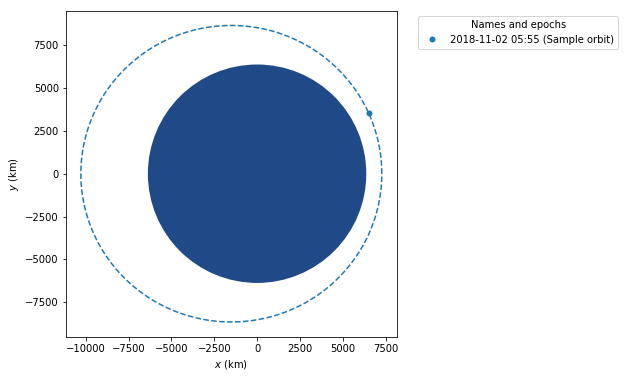

In [4]:
plot(ss, label="Sample orbit");

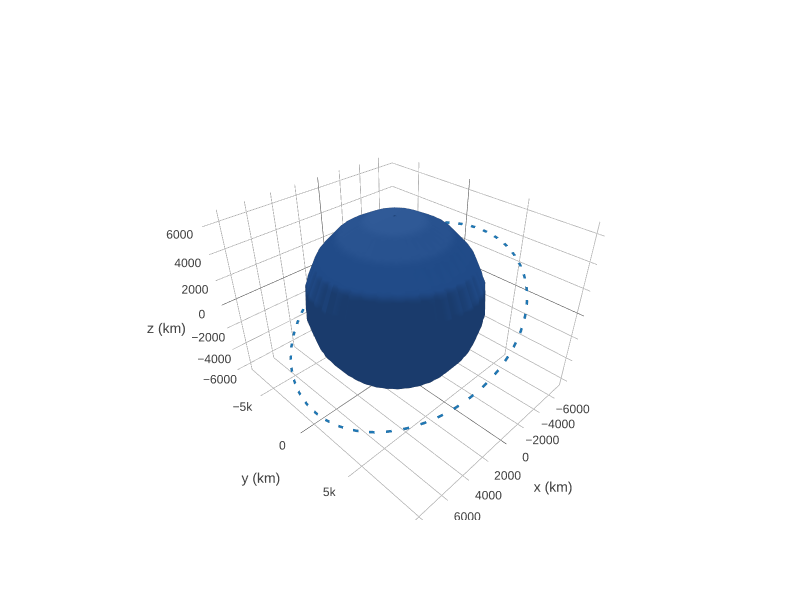

In [5]:
plot3d(ss, label="Sample orbit");

### External data

* Planetary ephemerides
  - SPICE kernels
* Near Earth Objects (NEOs)
  - NeoWs https://api.nasa.gov/neo/?api_key=DEMO_KEY
  - DASTCOM5 database ftp://ssd.jpl.nasa.gov/pub/ssd/README.txt

In [6]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [7]:
Orbit.from_body_ephem(Earth)

1 x 1 AU x 23.4 deg (ICRS) orbit around Sun (☉) at epoch 2018-11-02 05:58:01.487571 (TDB)

In [8]:
from poliastro.neos import neows

florence = neows.orbit_from_name("Florence")
florence

1 x 3 AU x 22.1 deg (HeliocentricEclipticJ2000) orbit around Sun (☉) at epoch 2458600.5 (TDB)

In [9]:
from poliastro.neos import dastcom5

halley_1835 = dastcom5.orbit_from_name('1P')[30]
halley_1835

1 x 35 AU x 162.3 deg (HeliocentricEclipticJ2000) orbit around Sun (☉) at epoch 2391600.5 (TDB)

In [10]:
from poliastro.plotting import OrbitPlotter, plot_solar_system
from poliastro.bodies import Mercury, Venus, Earth, Mars

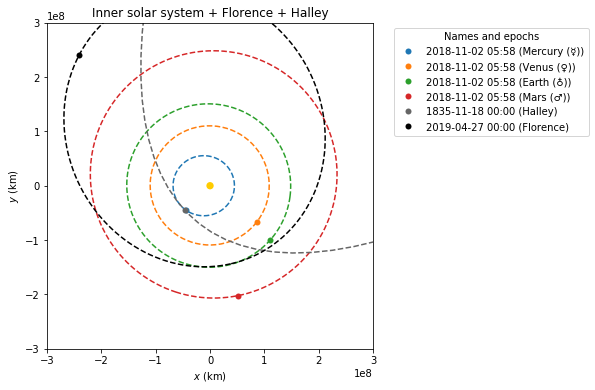

In [11]:
frame = plot_solar_system(epoch=Time.now().tdb, outer=False)

frame.plot(halley_1835, label='Halley', color='#666666')
frame.plot(florence, label='Florence', color='#000000')

plt.title("Inner solar system + Florence + Halley")
plt.xlim(-.3e9, .3e9)
plt.ylim(-.3e9, .3e9);

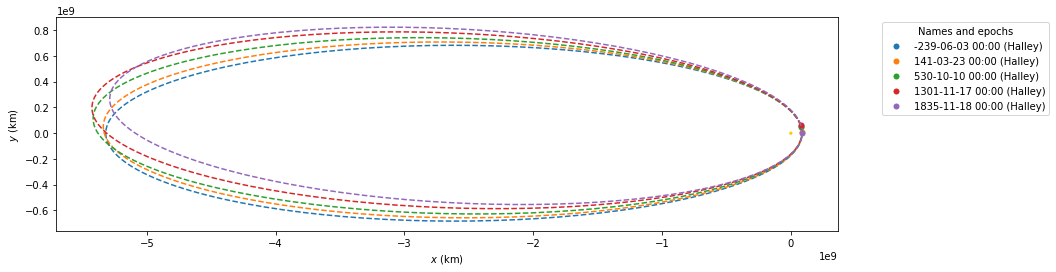

In [13]:
halleys = dastcom5.orbit_from_name('1P')

frame = OrbitPlotter(num_points=200)
frame.plot(halleys[0], label='Halley')
frame.plot(halleys[5], label='Halley')
frame.plot(halleys[10], label='Halley')
frame.plot(halleys[20], label='Halley')
frame.plot(halleys[30], label='Halley');

## Core algorithms

* Analytical propagation, aka Kepler's problem (_Battin universal variables approach_, _mean anomaly evolution_)
* Numerical propagation (_Cowell's method_)
* Boundary-value problem, aka Lambert's problem (_Izzo algorithm with multiple revolution_)
* Orbital maneuvers (_Hohmann's transfer, bielliptic transfer_)

In [ ]:
from poliastro.twobody.propagation import propagate, cowell
from poliastro.util import norm, time_range

from numba import njit

@njit
def accel(t0, state, k):
    """Constant acceleration aligned with the velocity. """
    v_vec = state[3:]
    norm_v = (v_vec * v_vec).sum() ** .5
    return 1e-5 * v_vec / norm_v

def custom_propagator(orbit, tof, rtol, accel=accel):
    # Workaround for https://github.com/poliastro/poliastro/issues/328
    if tof == 0:
        return orbit.r.to(u.km).value, orbit.v.to(u.km / u.s).value
    else:
        # Use our custom perturbation acceleration
        return cowell(orbit, tof, rtol, ad=accel)

In [ ]:
from poliastro.plotting import OrbitPlotter3D

frame = OrbitPlotter3D()

_, rr_earth = ss.sample(
   time_range(ss.epoch, end=ss.epoch + 3 * u.day, periods=300),
   method=custom_propagator
)

frame.set_attractor(Earth)
frame.plot_trajectory(rr_earth, label=Earth)
frame.show()

# Challenges

## Validation

> Unit testing a function with clear expectations is trivial. What are my expectations on numerical algorithms?

The wrooooooooooooooong way:

In [14]:
def sinc(x):
    return np.sin(x) / x

In [15]:
import pytest

In [16]:
@pytest.mark.parametrize("x", [0, 1, 10])
def test_sinc(x):
    assert sinc(x) == np.sin(x) / x

In [17]:
0.1 + 0.2 == 0.3

False

In [18]:
0.2 + 0.3 == 0.5

True

A better way:

* Compare against some authoritative source: **external data or software**
* Do floating point comparisons right and **use tolerances**
* Leverage advance features such as pytest **fixtures** and automatic test generation with hypotheses https://github.com/HypothesisWorks/hypothesis/

In [19]:
def test_convert_from_rv_to_coe():
    # Data from Vallado, example 2.6
    attractor = Earth
    p = 11067.790 * u.km
    ecc = 0.83285 * u.one
    inc = 87.87 * u.deg
    raan = 227.89 * u.deg
    argp = 53.38 * u.deg
    nu = 92.335 * u.deg
    expected_r = [6525.344, 6861.535, 6449.125] * u.km
    expected_v = [4.902276, 5.533124, -1.975709] * u.km / u.s

    r, v = ClassicalState(attractor, p, ecc, inc, raan, argp, nu).rv()

    assert_quantity_allclose(r, expected_r, rtol=1e-5)
    assert_quantity_allclose(v, expected_v, rtol=1e-5)

Still some issues:

* How much precision do you ask for? Should you carry a mathematical analysis?
* What if your results don't match? Sometimes, book or paper authors respond to your comments... And sometimes don't
* The changes in precision are a result of bad data, or worse algorithms?
* How do you even track _improvements_?

### External data (short summary)

* Nobody cares

* Those who care, don't share it

* Those who share, do it with 1 decimal place (true story)

* Those who share with 16 decimal places, don't describe how it was obtained (i.e. release the source)

* Those who release the source, make it impossible to compile

### External software

* Sometimes commercial
* Is it validated itself? (See above)
* It is often difficult to reproduce the exact setting and algorithms, most of the times because your commercial software is much more complex

![Shrug](img/shrugging-guy.jpg)

...If you're really interested, go read my Final Masters Project: https://github.com/juanlu001/pfc-uc3m

## Performance and API design

* We want to be **as user friendly as possible**
* This includes protecting the user from common mistakes
* Two annoying sources of errors: physical units and reference frames

![Mars Climate Orbiter](img/mco.png)

* But performance comes at a price
* _Yes, Python is slow_ (compared to compiled languages)
* The places where we don't notice it is because the underlying code is compiled (e.g. NumPy)

Then, how to accelerate the code?

## Vectorization

* Rewriting some code leveraging high level NumPy functions can make it way faster
* However, this works best for array manipulation - some other algorithms cannot easily be vectorized
* And even if you can, vectorized code can be impossible to read

![Too smart](img/too_smart.png)

## Cython

![Cython](img/Cython-logo.png)

* Mature, widely used, effective, gradual - a great project!
* Some personal problems with it:
  - I don't know any C, so it's more difficult for me
  - I wanted poliastro to be super easy to install by avoiding the "two language" problem (this includes Windows)
  - The native debugger is broken https://github.com/Juanlu001/cython-rasterio-debugging/issues/2
  - I really don't want to worry about some gore details

I don't have lots of experience with it, so I don't have solid arguments against it.

## PyPy

![PyPy](img/pypy-logo.png)

* PyPy is a super interesting alternative Python implementation https://pypy.org/
* I really really want to use it more, but there are some obstacles:
  - The documentation is a bit poor, even the changelogs
  - Lacks interest from the mainstream community (including snarky comments by Guido about "nobody using it in production")
  - Support in conda is half-broken https://github.com/conda-forge/pypy2.7-feedstock/issues/1
  - PyPy has several incompatibilities with manylinux1 wheels https://bitbucket.org/pypy/pypy/issues/2617/
  - manylinux2010 are almost there, but need the final push https://github.com/pypa/manylinux/issues/179

## numba

![numba](img/numba-logo.png)

* numba is a Python-to-LLVM JIT compiler
* When it works, it's super effective and the results are impressive!
* Debugging improved _a lot_ lately
* However, its focus is numerical code: it won't accelerate high level Python features
* At the moment it's not even possible to pass a function as an argument, impeding reusability https://github.com/numba/numba/issues/2952

In [23]:
import random

In [32]:
def monte_carlo_pi(nsamples):
    acc = 0
    for ii in range(nsamples):
        x = random.random()
        y = random.random()
        if x ** 2 + y ** 2 < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [33]:
print(monte_carlo_pi(10))
print(monte_carlo_pi(1_000_000))

2.4
3.142732


In [34]:
%timeit monte_carlo_pi(1_000_000)

390 ms ± 9.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
from numba import njit  # Forget about jit! Only nopython mode

fast_monte_carlo_pi = njit(monte_carlo_pi)

In [37]:
%timeit -n1 -r1 fast_monte_carlo_pi(1_000_000)

17.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [38]:
%timeit fast_monte_carlo_pi(1_000_000)

12.7 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
import numbannotate

In [60]:
%%numba_annotate
from numba import jit  # https://github.com/numba/numba/issues/2788#issuecomment-435288763

@jit
def monte_carlo_pi(nsamples):
    acc = 0
    for ii in range(nsamples):
        x = random.random()
        y = random.random()
        if x ** 2 + y ** 2 < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

print(monte_carlo_pi(1_000_000))

label 0
4: def monte_carlo_pi(nsamples):
"nsamples = arg(0, name=nsamples) :: pyobject"
"$const0.1 = const(int, 0) :: pyobject"
acc = $const0.1 :: pyobject
del $const0.1
jump 4
label 4
label 5
"acc = arg(0, name=acc) :: pyobject"
"nsamples = arg(1, name=nsamples) :: pyobject"


## Solution

So... let's make our code Fortran-esque!

<img src="img/architecture.svg" alt="Architecture" width="500" style="float:right"></img>

High level API:

* Supports mixed units and time scales, figures out the rest
* Easy to use and impossible to get wrong
* **Slow**

Dangerous™ algorithms:

* **Fast** (easy to accelerate with numba or Cython)
* Only cares about numbers, makes assumptions on units (SI, TBD)
* **You can mess it up**

<div style="clear:both"></div>

In [61]:
@u.quantity_input(E=u.rad, ecc=u.one)
def E_to_nu(E, ecc):
    """True anomaly from eccentric anomaly."""
    return (E_to_nu_fast(E.to(u.rad).value, ecc.value) * u.rad).to(E.unit)

### Measure everything!

http://poliastro.github.io/poliastro-benchmarks

![Benchmarks](img/benchmarks.png)

## Community building

> I believe the choice of license is an important one, and I advocate a BSD-style license. **In my experience, the most important commodity an open source project needs to succeed is users.**
>
> -- John Hunter † http://nipy.org/nipy/faq/johns_bsd_pitch.html

* Sometimes, language wins over performance.
* Sometimes, documentation wins over features.
* Sometimes, marketing wins over quality.

_Go find your users!_

# How to contribute?

* First and foremost: **no astrodynamics knowledge required!**
* Lots of issues with plotting, testing, internal design...
* Everything that fits de scope https://github.com/poliastro/poliastro#can-i-do-insert-awesome-thing-with-poliastro and is aligned with the vision https://github.com/poliastro/poliastro/wiki/Core-principles is welcome!
* If you use the library and find bugs or outdated docs, we would love to know!
* And if you do something cool, we can publish a success story https://docs.poliastro.space/en/latest/#success-stories
* Comment on issues, join our chat, let's talk!

# _Per Python ad astra!_ 🚀

* Slides: https://github.com/poliastro/piterpy5-talk
* poliastro chat: https://riot.im/app/#/room/#poliastro:matrix.org
* Twitter: https://twitter.com/poliastro_py

## большое спасибо!

![Rocket](img/soyuz.jpg)